In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.lstm_vae1cell import *
import torch
import random
from config import *
import sys
sys.path.append('../esa')
from esa.utils import *
from esa.lstm_utils import *

from omegaconf import OmegaConf
from notebook_utils import launch_train_advice

import numpy as np

architecture = 'lstm_vae1cell'
os.environ['architecture'] = architecture
config_file = os.path.join(conf_path, architecture+'.yaml')
cfg = OmegaConf.load(config_file)
cfg.dataset.out_window = cfg.dataset.sequence_length

In [6]:
model_list = os.listdir(model_results+ '{}/'.format(architecture))
for ix, mn in enumerate(model_list):  
    print('model num {}: {}'.format(ix,model_list[ix]))

model num 0: lstm_vae1cell_sl_16_emb_64_layers_1_recon_loss_custom_22_03_2023_16:25:43.pth


In [7]:
launch_train_advice(cfg, model_list, config_file)

to train a model  switch train_model to True  in the next cell
to train a new model from scratch set train_model to True in the next cell

check the configuration file in /home/roberto/Documents/backup_rob/repo/esa_fdir/time_series_anomaly_detection/configuration/lstm_vae1cell.yaml to set the hyperparameters of the model

actual dataset configuration is {'name': 'all_2016-2018_clean_std_4s.pkl', 'sequence_length': 16, 'columns': ['RW1_motcurr', 'RW2_motcurr', 'RW3_motcurr', 'RW4_motcurr', 'RW1_cmd_volt', 'RW2_cmd_volt', 'RW3_cmd_volt', 'RW4_cmd_volt', 'RW1_therm', 'RW2_therm', 'RW3_therm', 'RW4_therm', 'RW1_speed', 'RW2_speed', 'RW3_speed', 'RW4_speed'], 'train_val_split': 0.7, 'shuffle': 0, 'columns_subset': 0, 'dataset_subset': 100000, 'batch_size': 500, 'sampling_rate': '4s', 'scaled': 1, 'target': None, 'forecast': 0, 'forecast_all': 0, 'predict': 0, 'out_window': 16}

actual architecture configuration is {'architecture': 'lstm_vae1cell', 'embedding_dim': 64, 'latent_dim': 100, 'n_

In [8]:
model_list = os.listdir(model_results+ '{}/'.format(architecture))
for ix, mn in enumerate(model_list):  
    print('model num {}: {}'.format(ix,model_list[ix]))

model num 0: lstm_vae1cell_sl_16_emb_64_layers_1_recon_loss_custom_22_03_2023_16:25:43.pth


In [10]:
selected_model = 0
print(model_list[selected_model])
model_name = model_list[selected_model].split('.')[0]

lstm_vae1cell_sl_16_emb_64_layers_1_recon_loss_custom_22_03_2023_16:25:43.pth


In [11]:
train_model = True

In [12]:
if train_model:
    !python ../main.py --config_name $architecture

now = 2023-03-23 11:49:53.683142
LSTM_VAE1cell(
  (encoder): Encoder_vae1cell(
    (act2): InverseSquareRootLinearUnit()
    (ClippedTanh0): ClippedTanh0()
    (LSTMenc): LSTM(16, 64, batch_first=True)
    (mu): Linear(in_features=64, out_features=100, bias=True)
    (dispersion): Linear(in_features=64, out_features=100, bias=True)
  )
  (decoder): Decoder_vae1cell(
    (act2): InverseSquareRootLinearUnit()
    (act3): ClippedTanh()
    (LSTMdec): LSTM(1, 64, batch_first=True)
    (latent_to_hidden): Linear(in_features=100, out_features=64, bias=True)
    (par1): Linear(in_features=64, out_features=16, bias=True)
    (par2): Linear(in_features=64, out_features=16, bias=True)
    (par3): Linear(in_features=64, out_features=16, bias=True)
  )
)
  0%|                                                | 0/140 [00:00<?, ?batch/s]Loss:
loss 14.35700798034668: recon loss 12.630624771118164 and kld 2.8773045539855957 mse_loss 1.0058324337005615
14.35700798034668

  6%|██▌                         

100%|██████████████████████████████████████| 140/140 [00:11<00:00, 12.35batch/s]

Evaluating: 100%|███████████████████████████████| 60/60 [00:02<00:00, 21.07it/s]
eval loss 10.738744735717773
val_loss improved from 10000000000000000 to 10.738744735717773, saving model  lstm_vae1cell_sl_16_emb_64_layers_1_recon_loss_custom_23_03_2023_11:49:53 to /home/roberto/Documents/backup_rob/repo/esa_fdir/time_series_anomaly_detection/model_results/lstm_vae1cell
eval loss 10.738744735717773
  0%|                                                | 0/140 [00:00<?, ?batch/s]Loss:
loss 9.59894847869873: recon loss 9.029143333435059 and kld 0.9496753811836243 mse_loss 1.2712421417236328
9.59894847869873

  7%|██▊                                    | 10/140 [00:01<00:12, 10.13batch/s]Loss:
loss 9.314608573913574: recon loss 8.78386116027832 and kld 0.8845790028572083 mse_loss 1.202742576599121
9.314608573913574

 14%|█████▌                                 | 20/140 [00:02<00:09, 12.35batch/s]Loss:
loss 8.96


 79%|█████████████████████████████▊        | 110/140 [00:08<00:02, 12.90batch/s]Loss:
loss 7.615693092346191: recon loss 7.237679481506348 and kld 0.6300222873687744 mse_loss 1.4074996709823608
7.615693092346191

 86%|████████████████████████████████▌     | 120/140 [00:09<00:01, 13.32batch/s]Loss:
loss 7.691997528076172: recon loss 7.344943523406982 and kld 0.5784233212471008 mse_loss 1.4496835470199585
7.691997528076172

 93%|███████████████████████████████████▎  | 130/140 [00:10<00:00, 13.78batch/s]Loss:
loss 7.548618793487549: recon loss 7.216275215148926 and kld 0.5539061427116394 mse_loss 1.393556833267212
7.548618793487549

100%|██████████████████████████████████████| 140/140 [00:11<00:00, 12.47batch/s]

Evaluating: 100%|███████████████████████████████| 60/60 [00:02<00:00, 24.35it/s]
eval loss 8.77993106842041
val_loss improved from 10.738744735717773 to 8.77993106842041, saving model  lstm_vae1cell_sl_16_emb_64_layers_1_recon_loss_custom_23_03_2023_11:49:53 to /home/roberto/Doc

 56%|██████████████████████                 | 79/140 [00:06<00:04, 13.37batch/s]Loss:
loss 6.461165428161621: recon loss 5.788825988769531 and kld 1.120565414428711 mse_loss 1.4583216905593872
6.461165428161621

 64%|████████████████████████▊              | 89/140 [00:07<00:03, 12.90batch/s]Loss:
loss 5.968146324157715: recon loss 5.338798522949219 and kld 1.0489128828048706 mse_loss 1.4889137744903564
5.968146324157715

 71%|███████████████████████████▌           | 99/140 [00:08<00:03, 12.99batch/s]Loss:
loss 5.65600061416626: recon loss 5.03294563293457 and kld 1.0384247303009033 mse_loss 1.5245137214660645
5.65600061416626

 78%|█████████████████████████████▌        | 109/140 [00:09<00:02, 13.29batch/s]Loss:
loss 5.798496723175049: recon loss 5.183136940002441 and kld 1.025599718093872 mse_loss 1.5471398830413818
5.798496723175049

 85%|████████████████████████████████▎     | 119/140 [00:09<00:01, 13.55batch/s]Loss:
loss 5.737095355987549: recon loss 5.07447624206543 and kld 1.10436

In [13]:
if train_model:
    model_list = os.listdir(model_results+ '{}/'.format(architecture))
    for ix, mn in enumerate(model_list):  
        print('model num {}: {}'.format(ix,model_list[ix]))

model num 0: lstm_vae1cell_sl_16_emb_64_layers_1_recon_loss_custom_22_03_2023_16:25:43.pth
model num 1: lstm_vae1cell_sl_16_emb_64_layers_1_recon_loss_custom_23_03_2023_11:49:53.pth


In [14]:
selected_model = 0
print(model_list[selected_model])
model_name = model_list[selected_model].split('.')[0]

lstm_vae1cell_sl_16_emb_64_layers_1_recon_loss_custom_22_03_2023_16:25:43.pth


In [5]:
try:
    sm = str(torch.cuda.get_device_capability())
    sm = ''.join((sm.strip('()').split(',')[0], sm.strip('()').split(',')[1])).replace(' ', '')
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda and sm in torch.cuda.get_arch_list() else "cpu")
except:
    device='cpu'

In [6]:
checkpoint  = torch.load(model_results+ '{}/'.format(architecture) + '/' + model_list[selected_model],
                        map_location=device)
params_conf = checkpoint['param_conf']

In [9]:
cols = params_conf['columns']
sequence_length = params_conf['sequence_length']
batch_size = params_conf['batch_size']
predict = params_conf['predict']

out_window = params_conf['out_window']

n_features = params_conf['n_features']
scaled = params_conf['scaled']
sampling_rate = params_conf['sampling_rate']

data_path = params_conf['data_path']

In [23]:
batch_size = 10

In [25]:
dataset_name = os.path.join(data_path.strip('..'), "all_2016-2018_clean_std_4s.pkl")
transform = None
df_train, df_test, train_iter, test_iter = \
read_dataset(dataset_name=dataset_name, scaled=params_conf['scaled'], cols=params_conf['columns'],
columns_subset=params_conf['columns_subset'], dataset_subset=params_conf['dataset_subset']
, sequence_length=params_conf['sequence_length'],out_window=params_conf['sequence_length'], 
train_val_split=params_conf['train_val_split'], batch_size=batch_size , transform=transform)  

In [40]:
model = LSTM_VAE1cell(seq_in=params_conf['sequence_length'],seq_out=params_conf['out_window'],
        no_features=params_conf['n_features'], output_size=params_conf['n_features'],
        embedding_dim=params_conf['embedding_dim'], latent_dim=params_conf['latent_dim'],
        Nf_lognorm=params_conf['n_features'], Nf_binomial=0, n_layers_1=params_conf['n_layers_1'],
        kld_type=params_conf['kld'], recon_loss_type=params_conf['recon_loss'], batch_size=10)
par_nums = count_parameters(model)
print('number of params', par_nums)

LSTM_VAE1cell(
  (encoder): Encoder_vae1cell(
    (act2): InverseSquareRootLinearUnit()
    (ClippedTanh0): ClippedTanh0()
    (LSTMenc): LSTM(16, 64, batch_first=True)
    (mu): Linear(in_features=64, out_features=100, bias=True)
    (dispersion): Linear(in_features=64, out_features=100, bias=True)
  )
  (decoder): Decoder_vae1cell(
    (act2): InverseSquareRootLinearUnit()
    (act3): ClippedTanh()
    (LSTMdec): LSTM(1, 64, batch_first=True)
    (latent_to_hidden): Linear(in_features=100, out_features=64, bias=True)
    (par1): Linear(in_features=64, out_features=16, bias=True)
    (par2): Linear(in_features=64, out_features=16, bias=True)
    (par3): Linear(in_features=64, out_features=16, bias=True)
  )
)
number of params 60728


In [28]:
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()

LSTM_VAE1cell(
  (encoder): Encoder_vae1cell(
    (act2): InverseSquareRootLinearUnit()
    (ClippedTanh0): ClippedTanh0()
    (LSTMenc): LSTM(16, 64, batch_first=True)
    (mu): Linear(in_features=64, out_features=100, bias=True)
    (dispersion): Linear(in_features=64, out_features=100, bias=True)
  )
  (decoder): Decoder_vae1cell(
    (act2): InverseSquareRootLinearUnit()
    (act3): ClippedTanh()
    (LSTMdec): LSTM(1, 64, batch_first=True)
    (latent_to_hidden): Linear(in_features=100, out_features=64, bias=True)
    (par1): Linear(in_features=64, out_features=16, bias=True)
    (par2): Linear(in_features=64, out_features=16, bias=True)
    (par3): Linear(in_features=64, out_features=16, bias=True)
  )
)

In [29]:
compute_mse_val_loss = False

In [30]:
mse_val_loss_list = []
criterion = nn.MSELoss()
if compute_mse_val_loss:
    for i, (x,y) in enumerate(test_iter):
        yo = model(x)
        mse_val_loss_list.append(criterion(yo, x).item())
    mse_val_loss = np.mean(mse_val_loss_list)
    print(mse_val_loss)

In [34]:
num_batch = batch_size
inject_anomalies = False

x, shift = unrolling_batches(num_batch=num_batch, test_iter=test_iter, 
                         sequence_length=sequence_length, cols=cols, shift = None)

random shift 21406


In [35]:
x, mu, log_var, pars  = model(x.to(device))
yo = pars[0]

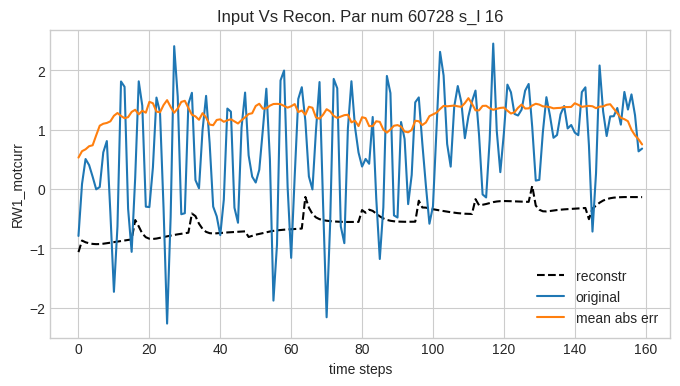

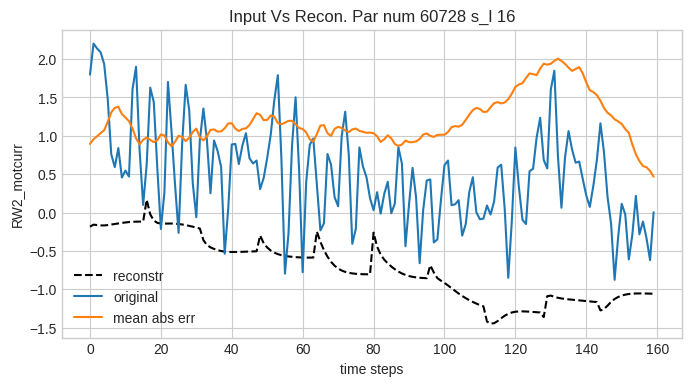

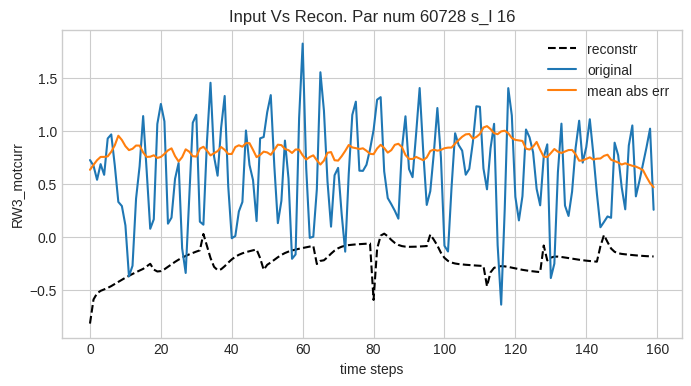

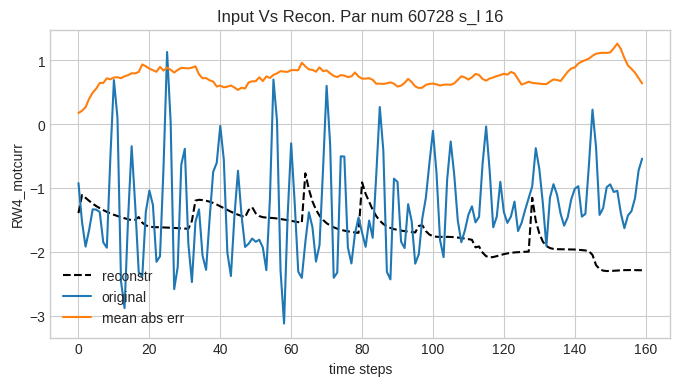

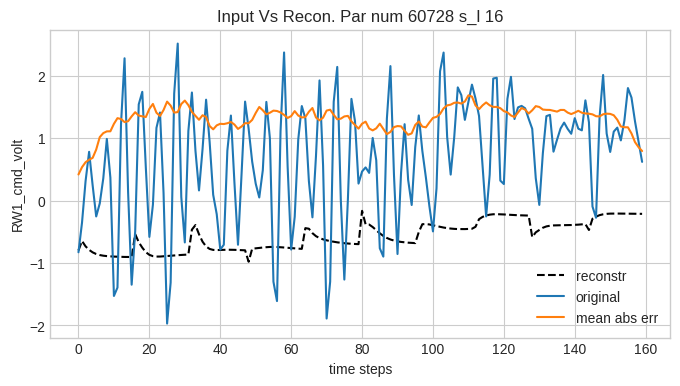

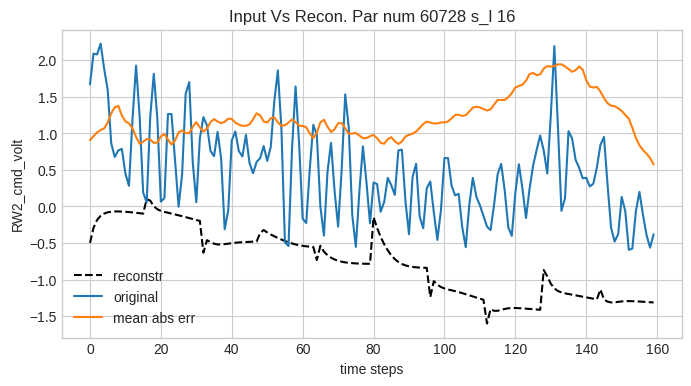

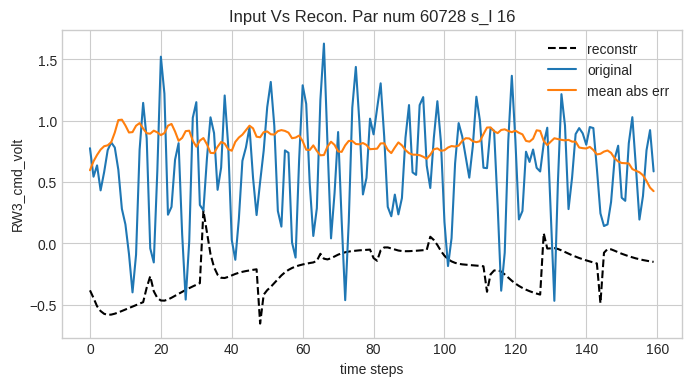

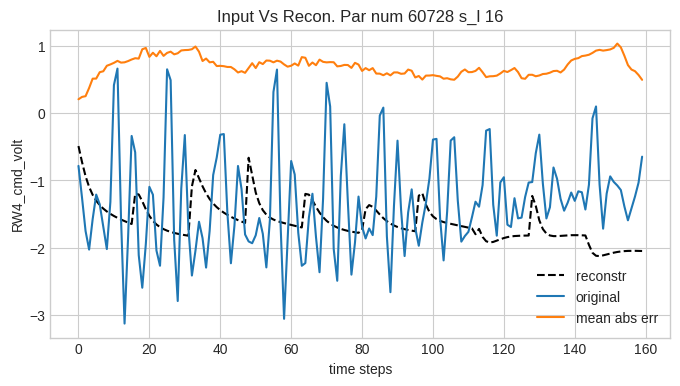

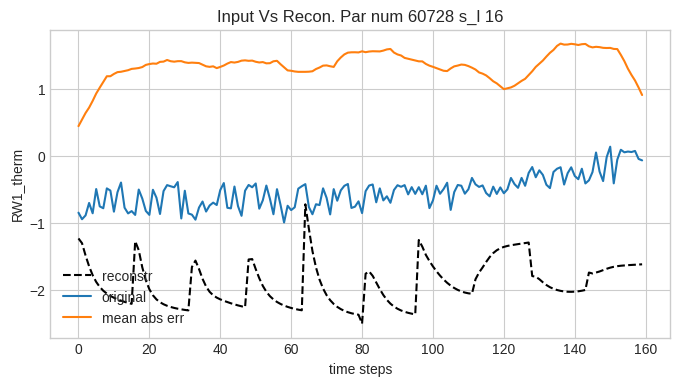

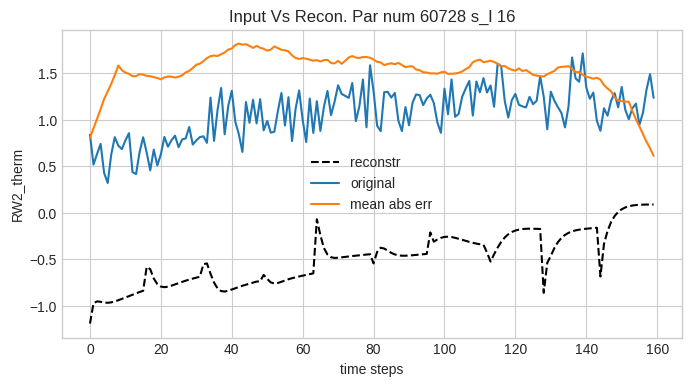

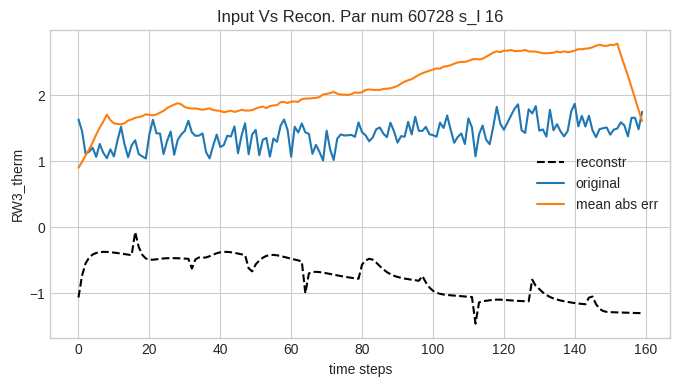

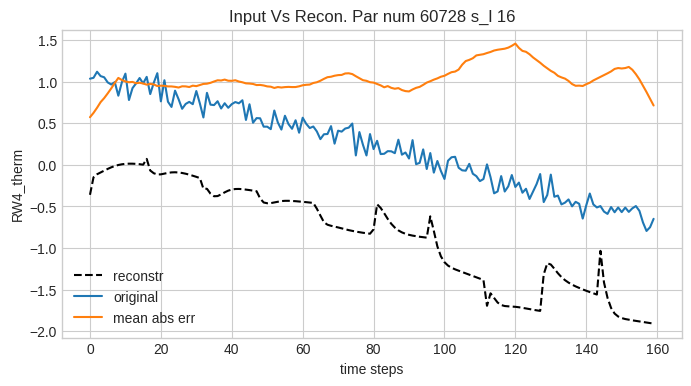

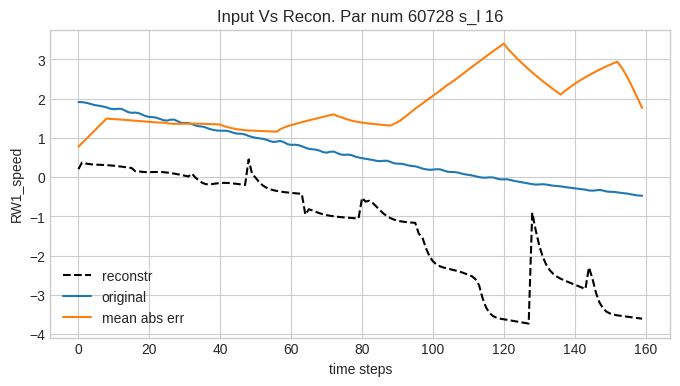

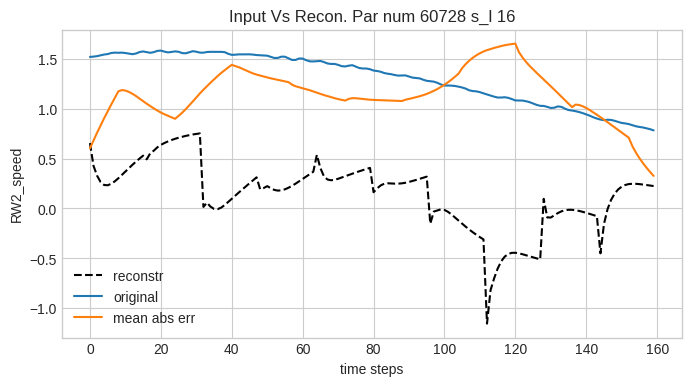

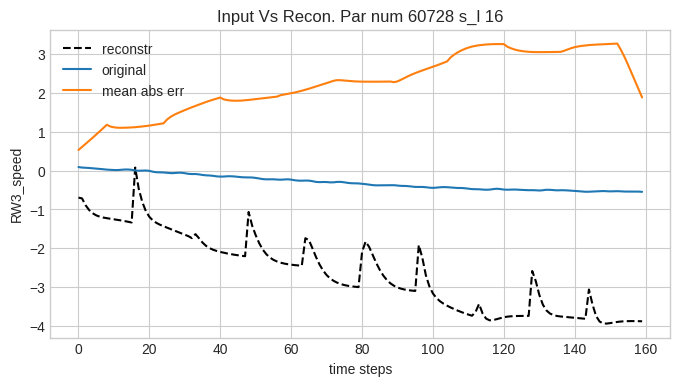

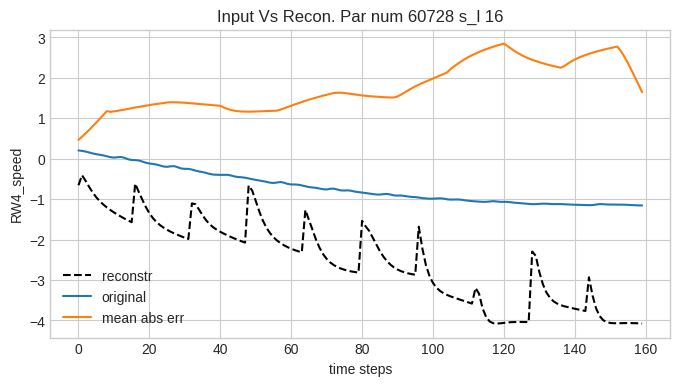

In [41]:
show_results(x, yo, cols, model_name, params_conf
     , par_nums, shift, num_batch,architecture=architecture,save=False)